In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from utils import *
plt.rcParams.update({'font.size': 20})

# Read North Foehn datasets and stack

In [2]:
location="LUG" # "PIO" or "LUG"

In [3]:
df_1983_2016 = pd.read_csv(f"data/FoehnData/{location}_1983_2016.txt", delimiter=",", header=0)
df_1983_2016["Date"] = pd.to_datetime(df_1983_2016["Date"], format='%Y%m%d%H%M')
df_1983_2016.rename(columns= {"Date": "date", "Foehn Index": "Foehn"}, inplace=True)

In [4]:
df_2017_2019 = pd.read_csv(f"data/FoehnData/{location}_2017_2019.txt", delimiter=";", skiprows=2, header=0)
df_2017_2019["time"] = pd.to_datetime(df_2017_2019["time"], format='%Y%m%d%H%M')
df_2017_2019.rename(columns= {"time": "date", "wcc006s0": "Foehn"}, inplace=True)
df_2017_2019 = df_2017_2019[["date", "Foehn"]]

In [5]:
# Stack dataframes.
df_1983_2019 = pd.concat([df_1983_2016, df_2017_2019], axis=0, ignore_index=True)

In [6]:
# Ensure continuoes and consistent values in the "date" column
df_timeframe = pd.Series(pd.date_range(start = "1983-01-01 00:00:00", end="2019-12-31 23:50:00", freq="10min"), name="date")
df_1983_2019 = pd.merge(df_timeframe, df_1983_2019, on="date", how="left", validate="one_to_one")

# Preprocess data

In [7]:
# Remove "-" from Foehn column and transform type to float
df_1983_2019["Foehn"] = df_1983_2019["Foehn"].mask(df_1983_2019["Foehn"] =="-", np.NaN)
df_1983_2019["Foehn"] = df_1983_2019["Foehn"].astype(float)

# Set all Foehn values (Foehn==2) to 1 (i.e. treat Mischluft as normal foehn)
df_1983_2019["Foehn"] = df_1983_2019["Foehn"].mask(df_1983_2019["Foehn"] == 2.0, 1.0)

In [33]:
# Calculate mean duration and number of foehn events
counter = 0
foehn_durations = []
for i in range(1,len(df_1983_2019.index)-1):
    print(i, end="\r")
    if df_1983_2019.loc[i, "Foehn"] == 1: 
        counter +=1
    elif df_1983_2019.loc[i-1, "Foehn"] == 1 and df_1983_2019.loc[i, "Foehn"] == 0 and df_1983_2019.loc[i+1, "Foehn"] == 1:
        counter +=1
    else:
        if counter:
            foehn_durations.append(counter*10)
            counter = 0
print(np.array(foehn_durations).mean())
print(len(foehn_durations))

448.027397260274
2920


In [8]:
# Define rolling window of length 6. If at least 4 dates show Foehn say there is foehn prevalent, otherwise not (refer to Gutermann et. al.(2013))
# Allow max 2 missing values (-> min_periods=4). Otherwise set entry to np.NaN
foehn_rolling_window=df_1983_2019["Foehn"].rolling(window=6, min_periods=4).sum().shift(-3)
foehn_new_representation = (foehn_rolling_window >= 4).astype(int)
foehn_new_representation.loc[foehn_rolling_window.isnull()] = np.NaN

df_rolling= df_1983_2019.copy()
df_rolling["Foehn"]= foehn_new_representation

In [9]:
# Keep only timestamps at full hour and where hour equals 0,6,12 or 18
date_mask = (df_rolling["date"].dt.minute==0) & \
            ((df_rolling["date"].dt.hour == 0) | 
            (df_rolling["date"].dt.hour == 6) |
            (df_rolling["date"].dt.hour == 12) |
            (df_rolling["date"].dt.hour == 18))
df_foehn =df_rolling.loc[date_mask]

In [24]:
# Sanity check
print(df_foehn.loc[df_foehn["date"]< "2019-08-31 23:00:00", "Foehn"].value_counts(normalize=False, dropna=True))
df_foehn.loc[df_foehn["date"]< "2019-08-31 23:00:00",:]

0.0    50032
1.0     3524
Name: Foehn, dtype: int64


,date,Foehn
0,1983-01-01 00:00:00,0.0
36,1983-01-01 06:00:00,0.0
72,1983-01-01 12:00:00,0.0
108,1983-01-01 18:00:00,0.0
144,1983-01-02 00:00:00,0.0
...,...,...
1928268,2019-08-30 18:00:00,0.0
1928304,2019-08-31 00:00:00,0.0
1928340,2019-08-31 06:00:00,0.0
1928376,2019-08-31 12:00:00,0.0


# Generate Climatology

In [11]:
# Create month and year column
df_foehn_frequency = df_1983_2019.copy()
df_foehn_frequency["month"] = df_foehn_frequency["date"].dt.month
df_foehn_frequency["year"] = df_foehn_frequency["date"].dt.year

In [12]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_foehn_frequency = df_foehn_frequency[["year", "month", "Foehn"]].groupby(["year", "month"], axis=0, as_index=False).mean()

Saved figure at: /home/chmony/Documents/Results/newgradient/Climatology_NorthFoehn.pdf


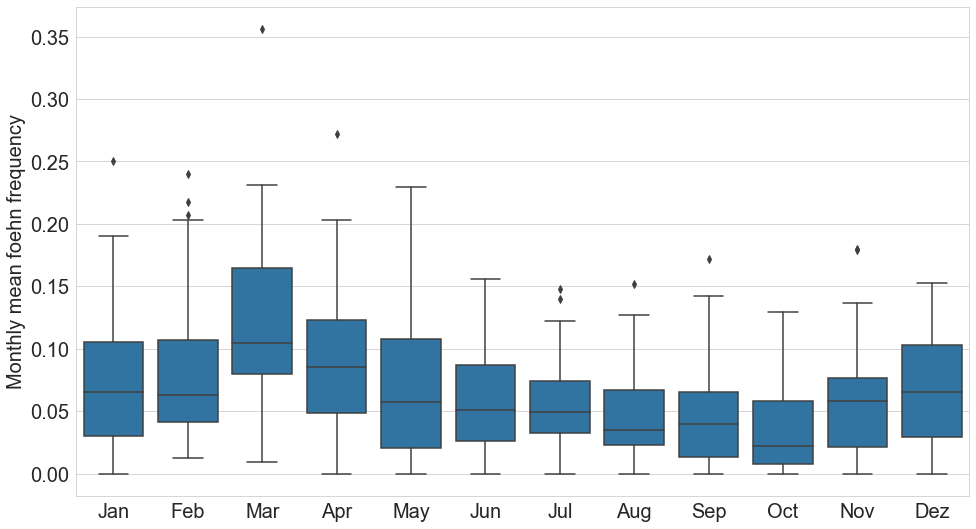

In [13]:
plt.figure(figsize=(16,9))
fig = sns.boxplot(x="month", y="Foehn", data=df_foehn_frequency, color="tab:blue")

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]
fig.set_xticklabels(MONTH_NAMES);
plt.xlabel("")
plt.ylabel("Monthly mean foehn frequency")
save_figure("Climatology_NorthFoehn")


# Write output

In [14]:
df_foehn.to_csv(f"data/FoehnData/{location}_foehn.csv", index=False)

# Make combined dataframe with foehn data

In [15]:
df_ERA = pd.read_csv("data/MeteorologicalData/ERAI_data.csv.gz", parse_dates=["date"])

In [16]:
df_foehn = df_foehn.dropna()

In [17]:
df_ERA_merged = pd.merge(df_foehn, df_ERA, on="date", how="inner")

In [18]:
df_ERA_merged.to_csv(f"data/FoehnAndMeteorologicalData/ERAI_and_North_Foehn_{location}_data.csv.gz", index=False)